# 4- Modeling CRISP-DM :

Modeling is the part of the Cross-Industry Standard Process for Data Mining (CRISP-DM) process model that i like best. Our data is already in good shape, and now we can search for useful patterns in our data.

# Faster R_CNN:

Faster-rcnn is a two-stage method comparing to one stage method like yolo, ssd, the reason faster-rcnn is accurate is because of its two stage architecture where the RPN is the first stage for proposal generation and the second classification and localisation stage learn more precise results based on the coarse grained result from RPN.
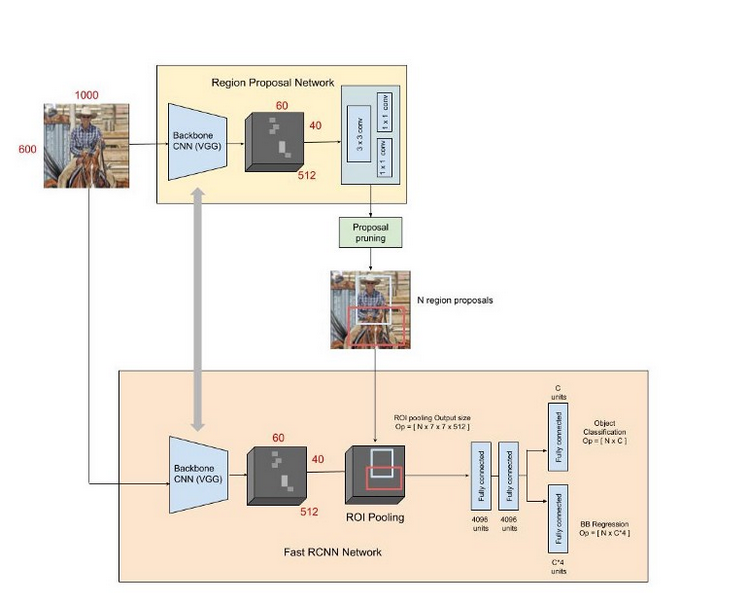

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from sklearn.metrics import average_precision_score
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy
from tensorflow.keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from tensorflow.keras import initializers, regularizers

Using TensorFlow backend.


# Implementing Faster R-CNN

For implementing the Faster R-CNN algorithm, we will be following the steps mentioned in this Github repository. So as the first step, make sure you clone this repository. Open a new terminal window and type the following to do this:

git clone https://github.com/kbardool/keras-frcnn.git

Move the train_images and test_images folder, as well as the train.csv file, to the cloned repository. In order to train the model on a new dataset, the format of the input should be:

filepath,x1,y1,x2,y2,class_name

where,

    filepath is the path of the training image
    x1 is the xmin coordinate for bounding box
    y1 is the ymin coordinate for bounding box
    x2 is the xmax coordinate for bounding box
    y2 is the ymax coordinate for bounding box
    class_name is the name of the class in that bounding box

We need to convert the .csv format into a .txt file which will have the same format as described above. Make a new dataframe, fill all the values as per the format into that dataframe, and then save it as a .txt file.
# Preapre data for Modeling 

In [2]:
import pandas as pd
import scipy.io
import warnings
import scipy.io
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import collections

warnings.filterwarnings('ignore')
def convert_mat_tocsv(mat):

  
    instances = mat['wiki'][0][0][0].shape[1]
    columns = ["dob", "photo_taken", "full_path", "gender",\
                "name", "face_location", "face_score", "second_face_score"]
    df = pd.DataFrame(index = range(0,instances), columns = columns)

    for i in mat:
        if i == "wiki":
            current_array = mat[i][0][0]
            for j in range(len(current_array)):
                df[columns[j]] = pd.DataFrame(current_array[j][0])
    return df

wiki_mat = scipy.io.loadmat('C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition_Fast_rcnn/TrainFacialRecognitonModel/wiki_crop/wiki_crop/wiki.mat')
wiki_Pandas=convert_mat_tocsv(wiki_mat)
#remove pictures does not include face
wiki_Pandas = wiki_Pandas[wiki_Pandas['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
wiki_Pandas = wiki_Pandas[wiki_Pandas['second_face_score'].isna()]
 
#check threshold
wiki_Pandas = wiki_Pandas[wiki_Pandas['face_score'] >= 3]
wiki_Selected =wiki_Pandas[ ['full_path', 'face_location', 'face_score']]



def flatten(x):
    if isinstance(x, collections.Iterable):
        return [int(a) for i in x for a in flatten(i)]
    else:
        return [x]
wiki_Selected['box1']=wiki_Selected['face_location'].apply(flatten)

wiki_Selected[['x1', 'y1', 'x2', 'y2']] = pd.DataFrame(wiki_Selected.box1.tolist(), index= wiki_Selected.index)
wiki_Selected1=wiki_Selected[['full_path', 'x1', 'y1', 'x2', 'y2']]

def creatingPath(x):
    return ("C:/Users/rzouga/Downloads/Github/CNN_CV/Face_Recognition_Fast_rcnn/TrainFacialRecognitonModel/wiki_crop/wiki_crop/"+x)

wiki_Selected1["filepath"] =wiki_Selected1["full_path"].str[0].apply(creatingPath)
wiki_Selected1['class_name']='face'
wiki_Selected1.columns

Index(['full_path', 'x1', 'y1', 'x2', 'y2', 'filepath', 'class_name'], dtype='object')

# select for modeling 

In [3]:
wiki_Selected_F=wiki_Selected1[['filepath', 'x1', 'y1', 'x2', 'y2', 'class_name']]
wiki_Selected_F.head()

,filepath,x1,y1,x2,y2,class_name
0,C:/Users/rzouga/Downloads/Github/CNN_CV/Face_R...,111,111,252,252,face
2,C:/Users/rzouga/Downloads/Github/CNN_CV/Face_R...,113,169,366,422,face
4,C:/Users/rzouga/Downloads/Github/CNN_CV/Face_R...,171,75,266,170,face
5,C:/Users/rzouga/Downloads/Github/CNN_CV/Face_R...,274,57,376,159,face
6,C:/Users/rzouga/Downloads/Github/CNN_CV/Face_R...,79,26,197,144,face


# Training DATASET

In [4]:
Train_wiki = wiki_Selected_F[:int(wiki_Selected_F.shape[0]*0.9)]


with open("Train_annotation.txt", "w+") as f: 
    for idx, row in Train_wiki.iterrows():
        sys.stdout.write(str(idx) + '\r')
        sys.stdout.flush()
        img = cv2.imread(row['filepath'])
        height, width = img.shape[:2] 
        x1 = int(row['x1']) 
        x2 = int(row['x2']) 
        y1 = int(row['y1']) 
        y2 = int(row['y2'])
        fileName = row['filepath']
        className = row['class_name']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

# Testing Dataset 

In [5]:
Test_wiki = wiki_Selected_F[int(wiki_Selected_F.shape[0]*0.9):]


with open("test_annotation.txt", "w+") as f: 
    for idx, row in Test_wiki.iterrows():
        sys.stdout.write(str(idx) + '\r')
        sys.stdout.flush()
        img = cv2.imread(row['filepath'])
        height, width = img.shape[:2] 
        x1 = int(row['x1']) 
        x2 = int(row['x2']) 
        y1 = int(row['y1']) 
        y2 = int(row['y2'])
        fileName = row['filepath']
        className = row['class_name']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

# Train our model

 We will be using the train_frcnn.py file to train the model.

**cd keras-frcnn
python train_frcnn.py -o simple -p Train_annotation.txt**

It will take a while to train the model due to the size of the data. If possible, you can use a GPU to make the training phase faster. You can also try to reduce the number of epochs as an alternate option. To change the number of epochs, go to the train_frcnn.py file in the cloned repository and change the num_epochs parameter accordingly.

Every time the model sees an improvement, the weights of that particular epoch will be saved in the same directory as “model_frcnn.hdf5”. These weights will be used when we make predictions on the test set.